#**Handson on Domain Decomposition Technique**

**Advanced Methods For Scientific Computing,**

Prof. Luca Formmagia, Dr. Paolo Joseph Baioni

Polimi, Nov 2025

**[GitHub Repo](https://github.com/AMSC-25-26/dd-02-dd)**

##Team 2-DD Members:

- Alessandro Russi
- Francesca Marina Pozzi
- Martina Rusconi
- Micaela Perlini
- Seyed Vahid Ghayoomie


# What do you have to do

For the hands-on, you should:
- implement a class to solve the problem (1). Note that you have a tridiagonal system so you can use the Thomas algorithm given in the Example. But you may choose instead to rely on the Eigen library.
- Implement the Schwarz iterator as a solver, with a class that is composed.
- implement the parallel version in MPI or OpenMP.
- have a way to shod the results (choose the graphic library or tool you prefer).

#**Solution**

In [ ]:
!git clone https://github.com/AMSC-25-26/dd-02-dd

In [6]:
%cd dd-02-dd/src

/content/dd-02-dd/src


## Thomas Solver

In [7]:
%%writefile test_sequential_solver.cpp

#include "sequential_solver.hpp"
#include "schwarz_solver.hpp"

int main(int argc, char** argv) {

    // Default parameters
    const int Nnodes = 200;            // total number of nodes in the 1D grid
    const double mu_in = 0.01;         // diffusion coefficient
    const double c_in = 5.0;           // reaction coefficient
    const double a = 0.0;              // left boundary of the domain
    const double b = 1.0;              // right boundary of the domain
    const double ua = 0.0;             // left Dirichlet BC
    const double ub = 0.0;             // right Dirichlet BC

    // ===== SEQUENTAL VERSION (only on Rank 0) =====
    std::vector<double> u_sequential;

    std::cout << "\n###############################################" << std::endl;
    std::cout << "  RUNNING SEQUENTIAL SOLVER" << std::endl;
    std::cout << "###############################################" << std::endl;

    SequentialSolver seq_solver(Nnodes, mu_in, c_in, a, b, ua, ub);
    seq_solver.solve();
    seq_solver.save_solution("sequential_solution.csv");
    u_sequential = seq_solver.get_solution();

    return 0;
}


Writing test_sequential_solver.cpp


In [8]:
!mpicxx test_sequential_solver.cpp sequential_solver.cpp -O2 -o test_sequential_solver -std=c++20

In [9]:
!./test_sequential_solver


###############################################
  RUNNING SEQUENTIAL SOLVER
###############################################

  SEQUENTIAL SOLVER COMPLETED
Sequential solution saved to 'sequential_solution.csv'



In [10]:
!head -n 10 sequential_solution.csv

x,u_s
0,0
0.00502513,0.0212459
0.0100503,0.0402348
0.0150754,0.0572066
0.0201005,0.0723755
0.0251256,0.085933
0.0301508,0.0980502
0.0351759,0.10888
0.040201,0.11856


## Eigen Solver

In [ ]:
!apt update
!apt install libeigen3-dev

In [12]:
%%writefile eigen_solver.cpp

#include <iostream>
#include <fstream>
#include <Eigen/Sparse>
#include <Eigen/SparseCholesky>

std::vector<double> eigen_solve(
    int N, double L, double mu, double c,
    const std::vector<double>& f)
{
    double h = L / (N + 1);

    Eigen::SparseMatrix<double> A(N, N);
    std::vector<Eigen::Triplet<double>> triplets;

    double diag = 2.0 * mu / (h*h) + c;
    double off  = -mu / (h*h);

    for (int i = 0; i < N; i++) {
        triplets.emplace_back(i, i, diag);
        if (i > 0)   triplets.emplace_back(i, i-1, off);
        if (i < N-1) triplets.emplace_back(i, i+1, off);
    }

    A.setFromTriplets(triplets.begin(), triplets.end());

    Eigen::VectorXd rhs(N);
    for (int i = 0; i < N; i++)
        rhs[i] = f[i];

    Eigen::SimplicialLLT<Eigen::SparseMatrix<double>> solver;
    solver.compute(A);

    Eigen::VectorXd u = solver.solve(rhs);

    std::vector<double> result(N);
    for (int i = 0; i < N; i++)
        result[i] = u[i];

    return result;
}


Writing eigen_solver.cpp


In [13]:
%%writefile test_eigen_solver.cpp

#include "eigen_solver.cpp"

void save(const std::string& name, const std::vector<double>& v) {
    std::ofstream out(name);
    for (auto x : v) out << x << "\n";
}

int main() {
    int N = 200;  // number of interior points
    double L = 1.0;
    double mu = 0.01;
    double c  = 5.0;
    double h = L/(N+1);

    // Build f(x) = sin(pi x)
    std::vector<double> f(N);
    for (int i = 0; i < N; i++) {
        double x = (i+1)*h;
        // f[i] = std::sin(M_PI * x);
        f[i] = 1.0;
    }

    auto u_eigen = eigen_solve(N, L, mu, c, f);
    save("u_eigen.txt", u_eigen);

    std::cout << "Files written: u_eigen.txt\n";
}

Writing test_eigen_solver.cpp


In [14]:
!g++ test_eigen_solver.cpp -I/usr/include/eigen3 -o test_eigen_solver

In [15]:
!./test_eigen_solver

Files written: u_eigen.txt


In [16]:
!head -n 10 u_eigen.txt

0.0210462
0.0398777
0.0567276
0.0718043
0.0852945
0.0973651
0.108165
0.117829
0.126476
0.134213


##Exact Solution

The exact solution for the equation in case $f(x)=sin(\pi x)$:

\begin{equation}
\boxed{
u(x)
=
\frac{1}{\mu \pi^2 + c}\,\sin(\pi x)
}
\end{equation}

In [17]:
# %%writefile exact_solution.cpp

# #include "eigen_solver.cpp"

# void save(const std::string& name, const std::vector<double>& v) {
#     std::ofstream out(name);
#     for (auto x : v) out << x << "\n";
# }

# int main() {

#     double mu = 0.01;
#     double c  = 5.0;


#     // Build f(x) = sin(pi x)
#     std::vector<double> f(N);
#     for (int i = 0; i < N; i++) {
#         double x = (i+1)*h;
#         f[i] = std::sin(M_PI * x);
#         // f[i] = 1.0;
#     }

#     std::vector<double> u_exact(N);
#     u_exact = f / (mu*M_PI*M_PI + c);

#     save("u_exact.txt", u_exact);

#     std::cout << "Files written: u_exact.txt\n";
# }

The exact solution for the equation in case $f(x) = 1.0$:

\begin{equation}
\boxed{
u(x)
=
\frac{1}{c}
\left[
1
-
\frac{\cosh\!\left(\lambda\left(x-\tfrac{L}{2}\right)\right)}
     {\cosh\!\left(\lambda\tfrac{L}{2}\right)}
\right]
, \qquad \lambda = \sqrt{\frac{c}{\mu}}
}
\end{equation}

General solution (LaTeX):


<IPython.core.display.Math object>


Exact solution with BCs (LaTeX):


<IPython.core.display.Math object>

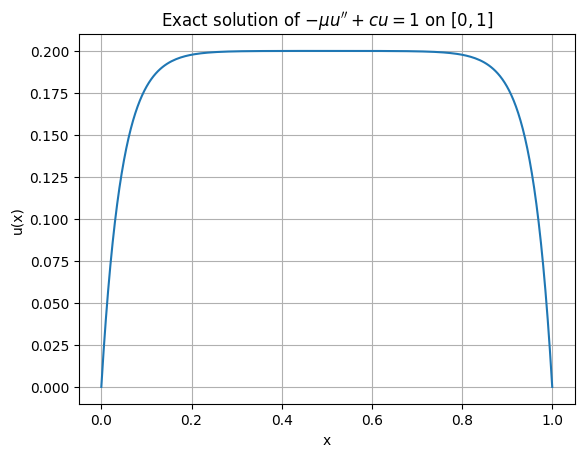

In [26]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

# -----------------------------
# Symbolic problem definition
# -----------------------------
x = sp.symbols('x')
mu, c = sp.symbols('mu c', positive=True)

u = sp.Function('u')

# PDE reduced to ODE
eq = -mu*sp.diff(u(x), x, 2) + c*u(x) - 1

# General symbolic solution
sol = sp.dsolve(eq)

# Print general solution in LaTeX
print("General solution (LaTeX):")
display(Math(sp.latex(sol)))

# -----------------------------
# Impose BCs: u(0)=u(1)=0
# -----------------------------
u_general = sol.rhs
C1, C2 = sp.symbols('C1 C2')

bc_eqs = [
    u_general.subs(x, 0),
    u_general.subs(x, 1)
]

constants = sp.solve(bc_eqs, (C1, C2))
u_exact = sp.simplify(u_general.subs(constants))

# Print exact solution in LaTeX
latex_exact = sp.latex(u_exact)
print("\nExact solution with BCs (LaTeX):")
display(Math(latex_exact))

# Write LaTeX to file
with open("u_exact.tex", "w") as f:
    f.write(r"\[" + "\n")
    f.write(latex_exact + "\n")
    f.write(r"\]" + "\n")

# -----------------------------
# Numerical evaluation on [0,1]
# -----------------------------
u_num = sp.lambdify(
    x,
    u_exact.subs({mu: 0.01, c: 5.0}),
    "numpy"
)

x_vals = np.linspace(0.0, 1.0, 200)
u_vals = u_num(x_vals)

# Write numerical solution to file
with open("u_exact.txt", "w") as f:
    for xi, ui in zip(x_vals, u_vals):
        f.write(f"{ui:.12e}\n")

# -----------------------------
# Plot
# -----------------------------
plt.figure()
plt.plot(x_vals, u_vals)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r"Exact solution of $-\mu u'' + c u = 1$ on $[0,1]$")
plt.grid(True)
plt.show()


In [27]:
!head -n 10 u_exact.txt

0.000000000000e+00
2.125644202981e-02
4.025370241882e-02
5.723189198491e-02
7.240560203754e-02
8.596661664749e-02
9.808633665060e-02
1.089179460230e-01
1.185983480094e-01
1.272498954748e-01


##Thomas vs Eigen vs Exact Solution

Relative L2 error = 8.466388287480638e-05


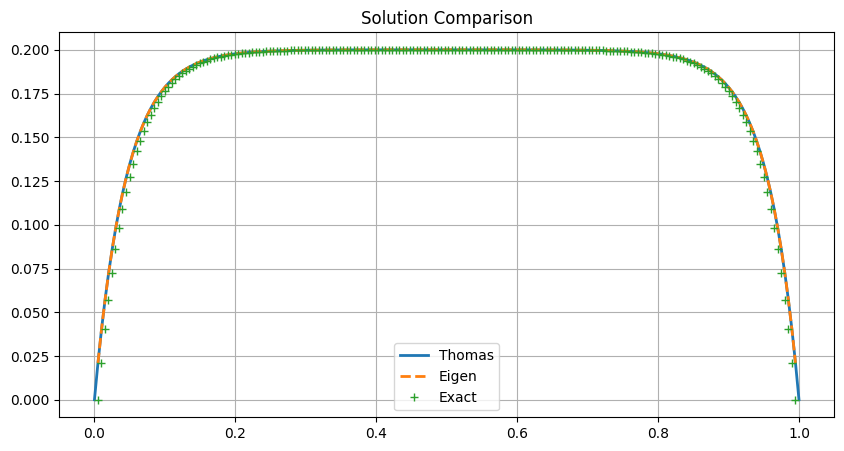

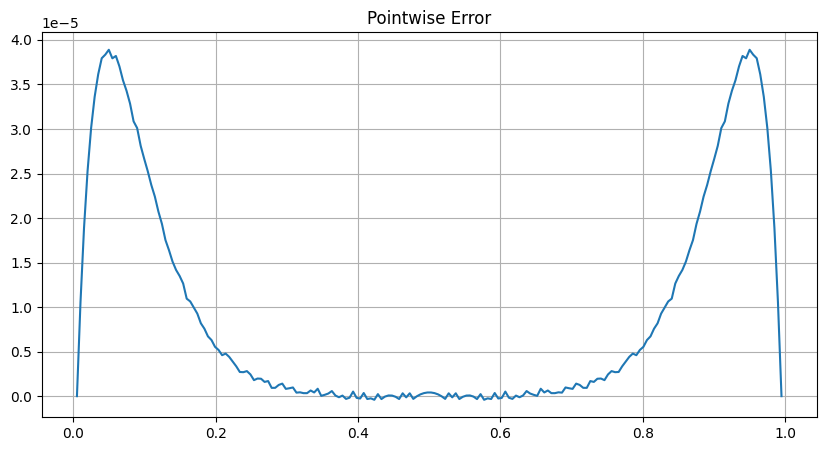

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os

thomas_solution_path = "sequential_solution.csv"
eigen_solution_path = "u_eigen.txt"
exact_solution_path = "u_exact.txt"

data_thomas = np.loadtxt(thomas_solution_path, delimiter=',', skiprows=1)
u_t = data_thomas.T[1]
x_t = data_thomas.T[0]

u_ei = np.loadtxt(eigen_solution_path)
u_ex = np.loadtxt(exact_solution_path)
x = np.linspace(0,1,len(u_t)+2)[1:-1]

# Compute error
err = u_ex - u_t
L2 = np.linalg.norm(err) / np.linalg.norm(u_ex)

print("Relative L2 error =", L2)

plt.figure(figsize=(10,5))
plt.plot(x_t, u_t, label="Thomas", linewidth=2)
plt.plot(x, u_ei, '--', label="Eigen", linewidth=2)
plt.plot(x, u_ex, '+', label="Exact", linewidth=2)
plt.title("Solution Comparison")
plt.legend()
plt.grid()

plt.figure(figsize=(10,5))
plt.plot(x, err, label="Error (Exact - Thomas)")
plt.title("Pointwise Error")
plt.grid()

plt.show()

##**TODOs:**
- Add function f(x) and a sample (e.g. sin(x)) to Thomas solver and try again
